# Titanic Challenge

In [97]:
t_train_orig = pd.read_csv("../data/raw/train.csv")
t_train_orig.name = "Titanic Training Set"
t_test_orig = pd.read_csv("../data/raw/test.csv")
t_test_orig.name = "Titanic Test Set"

###  Women were much more likely to survive than men

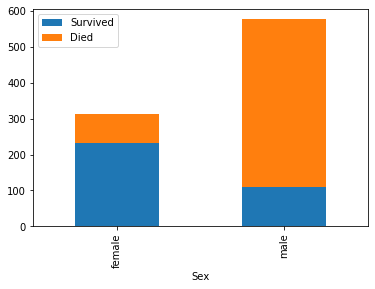

In [98]:
t_train_orig['Died']= t_train_orig['Survived'].map(lambda survived: 0 if survived == 1 else 1)
t_train_orig.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', stacked='true')

### Higher fare improves chance of survival

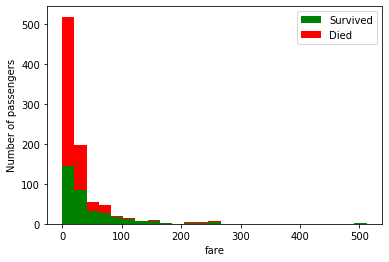

In [99]:
import matplotlib.pyplot as plt
t = t_train_orig
fare_survived =t[t['Survived'] == 1]['Fare'] 
fare_died = t[t['Survived'] == 0]['Fare'] 
plt.hist([fare_survived, fare_died], stacked=True, color = ['g', 'r'], 
         bins = 25, label=['Survived', 'Died'])
plt.xlabel('fare')
plt.ylabel('Number of passengers')
plt.legend()

### Class also improves chance of survival


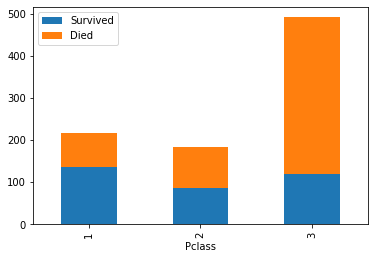

In [100]:
t_train_orig.groupby('Pclass').agg('sum')[['Survived', 'Died']].plot(kind='bar', stacked='true')

### Look for columns with missing values and fill them
Fill NAs in the training data for age, cabin, and embarked

In [103]:
def display_missing(df):    
    for col in df.columns.tolist(): 
        if df[col].isnull().sum() > 0:
            print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')

dfs = [t_train_orig, t_test_orig]

for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Titanic Training Set
Age column missing values: 177
Cabin column missing values: 687
Embarked column missing values: 2


Titanic Test Set
Age column missing values: 86
Fare column missing values: 1
Cabin column missing values: 327




In [402]:
t_train = t_train_orig

# fix age after we've extracted title, below

t_train['Cabin'].fillna('U')
import operator
embarked_group_counts = sorted(t_train.groupby('Embarked')['PassengerId'].count().items(), key=operator.itemgetter(1), reverse=True)
# fillNA for Embarked with the most common port code
t_train['Embarked'].fillna(embarked_group_counts[0][0])

0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: Embarked, Length: 891, dtype: object

### Sample training data

In [105]:
t_train_orig.sample(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Died
132,133,0,3,"Robins, Mrs. Alexander A (Grace Charity Laury)",female,47.0,1,0,A/5. 3337,14.5000,NaN,S,1
870,871,0,3,"Balkic, Mr. Cerin",male,26.0,0,0,349248,7.8958,NaN,S,1
538,539,0,3,"Risien, Mr. Samuel Beard",male,24.0,0,0,364498,14.5000,NaN,S,1
238,239,0,2,"Pengelly, Mr. Frederick William",male,19.0,0,0,28665,10.5000,NaN,S,1
608,609,1,2,"Laroche, Mrs. Joseph (Juliette Marie Louise La...",female,22.0,1,2,SC/Paris 2123,41.5792,NaN,C,0
447,448,1,1,"Seward, Mr. Frederic Kimber",male,34.0,0,0,113794,26.5500,NaN,S,0
173,174,0,3,"Sivola, Mr. Antti Wilhelm",male,21.0,0,0,STON/O 2. 3101280,7.9250,NaN,S,1
849,850,1,1,"Goldenberg, Mrs. Samuel L (Edwiga Grabowska)",female,37.0,1,0,17453,89.1042,C92,C,0


## Feature exploration for Decision Tree Classifier

Here are some initial ideas:
* Pclass (1 > 2 > 3)
* Fare ($$ > $)
* Sex (female > male)
* CabinPresent (1 > 0)
* Is child over 12 (1 > 0)


In [406]:
import math
from sklearn import preprocessing

t_train = t_train_orig

# sex to numeric
t_train['SexNumeric'] = np.where(t_train['Sex'] == "male", 0, 1)

# fill in missing fare with median fare for passengers in the same class
median_fares = t_train.groupby('Pclass')['Fare'].median()
def fare_for_class(row):
    return median_fares[row['Pclass']] if row['Fare'] == 0 else row['Fare']
t_train['FareAdjusted'] = t_train.apply(fare_for_class,axis=1)

# TODO: update AgeAdjusted to take into account title to refine the likely age, so that a child with
# missing age doesn't get classified as an adult.. a male child should be much more likely to survive
# so that should help

# extract titles
#get_index = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y][0]

t_train['Title'] = t_train_orig['Name'].map(lambda name: [title for title in name.split(' ') if '.' in title][0])
#all_titles = t_train['Title'].unique()
titles_esteemed_first = {
    'Countess.': 17,
    'Lady.': 16,
    'Rev.': 15,
    'Jonkheer.': 14,
    'Master.': 13,
    'Major.' : 12,
    'Don.': 11,
    'Dr.' : 10,
    'Col.': 9,
    'Capt.': 8,
    'Mlle.': 7,
    'Miss.': 6,
    'Ms.': 5,
    'Mrs.': 4,
    'Mme.': 3,
    'Sir.': 2,
    'Mr.': 1
}

median_age_by_class = t_train.groupby('Pclass')['Age'].median()
t_train['Age'] = t_train.apply(lambda row:
                    14 if row['Title'] == 'Miss.' else
                    median_age_by_class[row['Pclass']] if np.isnan(row['Age']) else row['Age'], axis=1)

t_train['TitleNumeric'] = t_train['Title'].map(lambda title: titles_esteemed_first[title])

feature_cols = ['FareAdjusted', 'Pclass', 'SexNumeric', 'TitleNumeric']
t_train[feature_cols].sample(12)

,FareAdjusted,Pclass,SexNumeric,TitleNumeric
368,7.7500,3,1,6
551,26.0000,2,0,1
23,35.5000,1,0,1
332,153.4625,1,0,1
53,26.0000,2,1,4
757,11.5000,2,0,1
335,7.8958,3,0,1
9,30.0708,2,1,4
882,10.5167,3,1,6
443,13.0000,2,1,5


## Using a Decision Tree Classifier

In [405]:
import pandas as pd

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

X_dt = t_train[feature_cols]
y_dt = t_train.Survived

X_train, X_test, y_train, y_test = train_test_split(X_dt, y_dt, test_size=0.3, random_state=1) # 70% training and 30% test

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7761194029850746


## Using a Random Forrest Classifier

### Additional features

In [519]:
t_train['Deck'] = \
    t_train['Cabin'].map(lambda cabin: cabin[0] if (type(cabin) == str) else "U")

# simply having s cabin assigned increases chances of survival
t_train['CabinGoodNumeric'] = \
t_train['Deck'].map(lambda letter: 1 if (letter in "BDEG") else 0)

def extractLast(name):
    parts = name.split(' ')  
    while (parts[0].islower()):
        parts = parts[1:]
    if (parts[0][-1] == ','):
        return parts[0][:-1]
    else: 
        return parts[0]
    
t_train['LastName'] = t_train_orig['Name'].map(extractLast) 

# Issue: multiple families with same last name get lumped together
familyGroup = t_train.groupby('LastName')['LastName'].count()
t_train['FamilyCount'] = t_train['LastName'].map(lambda last: familyGroup[last])

# This does not help
t_train['FamilyCountRels'] =  t_train['SibSp'] + t_train['Parch']

t_train[['Name','LastName', 'FamilyCount', 'SibSp', 'Parch']].sort_values(['LastName'], axis='rows').head(30)



,Name,LastName,FamilyCount,SibSp,Parch
845,"Abbing, Mr. Anthony",Abbing,1,0,0
279,"Abbott, Mrs. Stanton (Rosa Hunt)",Abbott,2,1,1
746,"Abbott, Mr. Rossmore Edward",Abbott,2,1,1
874,"Abelson, Mrs. Samuel (Hannah Wizosky)",Abelson,2,1,0
308,"Abelson, Mr. Samuel",Abelson,2,1,0
365,"Adahl, Mr. Mauritz Nils Martin",Adahl,1,0,0
401,"Adams, Mr. John",Adams,1,0,0
40,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",Ahlin,1,1,0
855,"Aks, Mrs. Sam (Leah Rosen)",Aks,1,0,1
207,"Albimona, Mr. Nassef Cassem",Albimona,1,0,0


### correlate deck with survival rate for assigned cabins

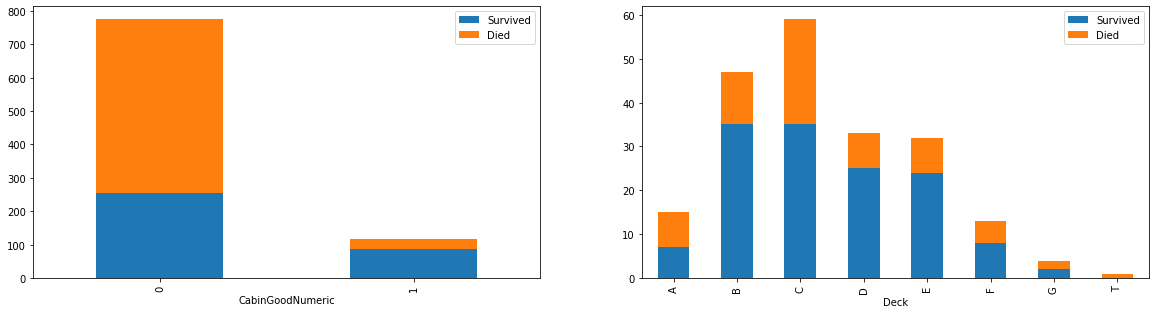

In [165]:
# correlate deck with survival rate for assigned cabins
import string
f, (ax1, ax2) = plt.subplots(1, 2, False, figsize=(20,5))
t_train_orig[t_train_orig['Deck'] != 'U'].groupby('Deck').agg('sum')[['Survived', 'Died']].plot(kind='bar', stacked='true', ax=ax2)
t_train_orig.groupby('CabinGoodNumeric').agg('sum')[['Survived', 'Died']].plot(kind='bar', stacked='true', ax=ax1)

# CabinGoodNumeric doesn't yet seem to inprove things.. can it be made to be useful?
# why is it not a very important feature according to random forrest.. is it because most people don't have a cabin?

In [153]:
t_train_corr = t_train_orig.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
t_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
groups = t_train_corr[(0.1 < t_train_corr["Correlation Coefficient"]) & (t_train_corr["Correlation Coefficient"] < .85)].groupby('Feature 1')
groups.get_group('Survived')

,Feature 1,Feature 2,Correlation Coefficient
20,Survived,SexNumeric,0.543351
33,Survived,TitleNumeric,0.364918
39,Survived,Pclass,0.338481
48,Survived,CabinGoodNumeric,0.284435
57,Survived,Fare,0.257307
60,Survived,FareAdjusted,0.250635


### Using OneHotEncoding

In [506]:
feature_cols_ohe = ['FareAdjusted', 'Pclass', 'SexNumeric', 'Title', 'Age', 'Deck']
X_ohe = t_train[feature_cols_ohe]

X_ohe = pd.concat([X_ohe,pd.get_dummies(X_ohe[['Title', 'Deck']], prefix=['Title', 'Deck'])],axis=1).drop(['Title', 'Deck'], axis=1)

# drop features that don't help (they got a 0.0000 feature importance score)
X_ohe = X_ohe.drop(['Title_Countess.', 'Deck_T', 'Title_Ms.', 'Title_Sir.', 'Title_Don.', 'Title_Capt.', 
                    'Title_Col.', 'Title_Mlle.', 'Title_Major.', 'Title_Lady.', 'Title_Jonkheer.', 
                    'Title_Mme.'] , axis=1)
X_ohe

,FareAdjusted,Pclass,SexNumeric,Age,Title_Dr.,Title_Master.,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Rev.,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_U
0,7.2500,3,0,22.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,71.2833,1,1,38.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,7.9250,3,1,14.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,53.1000,1,1,35.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,8.0500,3,0,35.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,13.0000,2,0,27.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
887,30.0000,1,1,14.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
888,23.4500,3,1,14.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
889,30.0000,1,0,26.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


### apply Random Forrest Classifier to the features


In [507]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

X_re = X_ohe
y_re = t_train.Survived

X_train, X_test, y_train, y_test = train_test_split(X_re, y_re, test_size=0.25, random_state=42)

rfc = RandomForestClassifier(n_estimators=250,
                             min_samples_split=3, min_samples_leaf=3, max_depth=15,
                             max_features=0.85, n_jobs=-1)

cv_results = cross_validate(rfc, X_re,y_re, return_train_score=True, return_estimator=True, cv=5)


print(f'Fit   Time:  {cv_results["fit_time"]}')
print(f'Score Time:  {cv_results["score_time"]}\n')
print(f'Train Score: {cv_results["train_score"]} (mean = {cv_results["train_score"].mean()})\n')
print(f'Test Score:  {cv_results["test_score"]} (mean = {cv_results["test_score"].mean()})\n')

from IPython.lib.pretty import pretty

estimators = list(cv_results['estimator'])

for i in range(len(estimators)):
    test_score = cv_results["test_score"][i]
    train_score = cv_results["train_score"][i]
    fit_time = cv_results["fit_time"][i]
    score_time = cv_results["score_time"][i]

    print(f"\ntest_score  = {test_score}")
    print(f"train_score = {train_score}")
    print(f"fit_time    = {fit_time}")
    print(f"score_time  = {score_time}\n")
    print(pd.DataFrame(estimators[i].feature_importances_,
                    index = X_re.columns,
                    columns=['importance']).sort_values('importance',ascending=False))      
   

Fit   Time:  [2.03363514 2.02161002 1.92724395 2.17034078 2.02853107]
Score Time:  [0.10826993 0.10981584 0.10718799 0.10900402 0.10789084]

Train Score: [0.9002809  0.91151685 0.88639551 0.89761571 0.89215686] (mean = 0.8975931671500881)

Test Score:  [0.83240223 0.81564246 0.88764045 0.80898876 0.84180791] (mean = 0.8372963631650192)


test_score  = 0.8324022346368715
train_score = 0.9002808988764045
fit_time    = 2.033635139465332
score_time  = 0.10826992988586426

               importance
Title_Mr.        0.249151
FareAdjusted     0.240813
SexNumeric       0.170896
Age              0.130736
Pclass           0.130007
Deck_U           0.028436
Deck_E           0.009909
Title_Master.    0.008964
Deck_C           0.006116
Title_Rev.       0.004862
Deck_B           0.004286
Title_Miss.      0.003875
Deck_D           0.003444
Title_Dr.        0.003158
Deck_A           0.002780
Title_Mrs.       0.002445
Deck_G           0.000121
Deck_F           0.000002

test_score  = 0.8156424581005587

In [508]:
from sklearn.model_selection import GridSearchCV

X_cv = X_ohe
y_cv = t_train.Survived

X_train, X_test, y_train, y_test = train_test_split(X_cv, y_cv, test_size=0.20, random_state=42)

rfc = RandomForestClassifier(min_samples_split=3, min_samples_leaf=3,
                             max_features=0.85, n_jobs=-1)

param_grid = {
    'max_depth': [4, 12, 18],
    'n_estimators': [50, 100, 250]}

search = GridSearchCV(rfc, param_grid, cv=5)

search.fit(X_cv, y_cv)

cv_resultsDF = pd.DataFrame(search.cv_results_, index=search.cv_results_['rank_test_score'])
cv_resultsDF.sort_values(by=['rank_test_score']).drop(['params'], axis='columns')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,2.097976,0.172896,0.110267,0.003514,18,50,0.832402,0.815642,0.887640,0.820225,0.853107,0.841751,0.026332,1
2,2.308428,0.054702,0.109084,0.001366,12,250,0.826816,0.810056,0.887640,0.820225,0.847458,0.838384,0.027478,2
2,1.960991,0.064771,0.109146,0.000507,18,100,0.832402,0.815642,0.876404,0.820225,0.847458,0.838384,0.021957,2
4,2.203565,0.097303,0.108324,0.001626,18,250,0.821229,0.804469,0.887640,0.825843,0.847458,0.837262,0.028660,4
5,2.249028,0.217167,0.109805,0.002245,12,50,0.826816,0.804469,0.876404,0.825843,0.841808,0.835017,0.023857,5
6,2.193532,0.343547,0.108174,0.001025,12,100,0.826816,0.798883,0.882022,0.803371,0.847458,0.831650,0.030606,6
7,2.389268,0.875026,0.110823,0.005776,4,100,0.832402,0.804469,0.837079,0.808989,0.841808,0.824916,0.015237,7
7,2.473131,0.220571,0.107067,0.001750,4,250,0.832402,0.810056,0.831461,0.808989,0.841808,0.824916,0.013097,7
9,2.034842,0.080948,0.108384,0.001391,4,50,0.832402,0.804469,0.825843,0.808989,0.847458,0.823793,0.015677,9


## Using Logistic Regression

In [115]:
from sklearn.linear_model import LogisticRegression

feature_cols = ['FareAdjusted', 'Pclass', 'SexNumeric', 'TitleNumeric']

X_lr = t_train[feature_cols]
y_lr = t_train.Survived
X_train, X_test, y_train, y_test = train_test_split(X_lr, y_lr, test_size=0.25, random_state=1) # 70% training and 30% test

lr = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X_train, y_train)
prob = lr.predict_proba(X_lr)

print(f'probabilty (count = {len(prob)}\n{prob}\n')
print(f'score: {clf.score(X_test, y_test)}')


probabilty (count = 891
[[0.93191471 0.06808529]
 [0.11022188 0.88977812]
 [0.40116983 0.59883017]
 ...
 [0.40131613 0.59868387]
 [0.64606079 0.35393921]
 [0.93191595 0.06808405]]

score: 0.8385650224215246


## Using K-Nearest Neighbors
because.. why not?

In [112]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[118  10]
 [ 37  58]]
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       128
           1       0.85      0.61      0.71        95

    accuracy                           0.79       223
   macro avg       0.81      0.77      0.77       223
weighted avg       0.80      0.79      0.78       223

